In [2]:
import itertools
from collections import Counter
from pprint import pprint
from copy import copy
from string import punctuation

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from blender import Blender
from wordcloud import WordCloud
from confusion_matrix import plot_confusion_matrix

/Users/family/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## Fake News Analysis

In recent months, the prevalence of "fake news" websites has been a topic of much conversation. Fake news websites publish news that is objectively untrue, usually political in nature, and often inflammatory. Fake news could be seen as a certain type of clickbait - its intent is to drive traffic to the website of origin and profit by selling advertisements. Fake news sites thrive on social media and can sometimes receive millions of shares on places like Facebook.

Due to the highly public role of fake news in the 2016 Presidential election, Facebook has come under fire as the platform where much of it has been shared. It would therefore be in their interest to develop a system to efficiently detect and eliminate fake news sites from website. However, this is a difficult problem to solve. First, Facebook has over a billion users and a similar amount of content being shared every day. It is therefore obviously not feasible to use a manual system to remove fake news websites and some algorithmic method would need to be implemented, at the minimum as the first pass of analysis. In addition, this is an extremely politically touchy subject. Should Facebook continue allowing users to share any piece of "news" they would like, they will continue to face criticism for allowing blatantly false information to proliferate and influence the social and political climate in our country. However, if they go too far in removing articles, they may face accusations of censorship or bias. Because of this, it's extremely important that any algorithm used on the site be very accurate.

For this project, I chose to implement some of the classification methods that we have learned in class to see how they fare in distinguishing fake news from real news. For my fake news corpus, I used a kaggle dataset consisting of 13,000 articles from known fake websites. For the real news corpus, I used a dataset released by the BBC consisting of 4,000 legitimate articles. I used a variety of classification techniques in order to test their efficacy.

In addition to using the general classifiers we learned in class, I also implemented a type of ensemble method known as "stacked generalization" or "blending". In blending, the outputs of several learners (the probabilities, not the final predicted classes) are used as input to a final learner, or "meta-learner". The input training space to the base learners is called the Level 0 training space, while the input to the meta-learner is known as the Level 1 training space.

Hypothetically, blending may be implemented using any number of levels. However, this is very computationally expensive and does not necessarily yield significantly better results.

In order to implement stacked generalization in the model, I created a Blender class that can implement a stacked generalizer using an arbitrary number of learning spaces. The class takes as input a dictionary of learners, where the entry for key n is the list of learners to be trained at level n in the learner.

## Conclusions

I elected to use a multinomial Naive Bayes as the baseline model. Using a TFIDF vectorization to encode the feature space, this model produces the following results:

#### Real news:

Precision: 96%  
Recall: 75%  
F-Score: 84%  

#### Fake news:  

Precision: 95%  
Recall: 99%  
F-Score: 97%  

#### Confusion Matrix

<img src="./naive_bayes_confusion_matrix.png" width=400, height=400>

Although the overall accuracy was good, this was mainly due to the fact that there were significantly more fake news articles than real news articles, and the model was quite good at identifying a fake news article.

However, the recall on real news was 90%, much lower than other values. This means that 10% of the total real news articles were being classified as fake. Although 90% is generally a pretty good score, as described above, a system like this in production would need to have better numbers. If this algorithm was a first pass, with the intent being to have a human review all flagged articles, 10% could ultimately be an infeasibly gigantic number at Facebook scale.

In addition to TFIDF and count vectorization, I trained a doc2vec model to convert the news articles to vectors. I trained a variety of models using all three vectorization methods.

One interesting method used was "stacked generalization" or "blending", which involves using the predictions of one or several "low level" learners as the feature space for a high level "meta learner". I wrote a generalized class for blending which can be found in stacked_generalizer.py. This class allows the user to train a blended model with an arbitrary number of levels as well as models per level.

Ultimately, the two best models were penalized logistic regression trained on the word2vec vectors and the blended model using logistic regression as the base learning and a support vector machine with and rbf kernel and gamma of 5 as the meta-learner. When training directly on the data, I used an SVM with a linear kernel because the data is of scuh high dimensionality that basis expansion does not really make sense. However, in the output probability space of the logistic regression, the dimensionality is reduced to 2, so the rbf kernel far outperformed the linear kernel.

The results were as follows:

#### Penalized Logistic Regression

Real News
- Precision: 95%
- Recall: 93%
- F-score: 94%

Fake News:
- Precision: 99%
- Recall: 99%
- F-score: 99%

<img src = 'logistic_regression_confusion_matrix.png' width=400, height=400>

#### Blended Model

Real News:
- Precision: 93%
- Recall: 94%
- F-score: 94%

Fake News:
- Precision: 99%
- Recall: 99%
- F-Score: 99%

<img src = 'blender_confusion_matrix.png' width=400, height=400>

Ultimately I would most likely use the logistic regression model in production because it is simple, fast, and only produced marginally worse results than the blended model.

All work is shown below.

## Pre-Processing

In [2]:
# convert stopwords and punctuation to sets for faster lookup
stopwords_lookup = set(stopwords.words('english'))
punctuation_lookup = set(punctuation)
stemmer = PorterStemmer()

def process_text(string_input, punctuation, stopwords, stem=True):
    for character in string_input:
        if character in punctuation:
            string_input = string_input.replace(character, "")

    processed_string = string_input.lower().split()

    processed_string = ' '.join([stemmer.stem(word) for word in processed_string if word not in stopwords])
    
    return processed_string

stopwords_lookup.add('said')
stopwords_lookup.add('mr')

In [3]:
fake_news = pd.read_csv('fake.csv')

fake_news_text = fake_news['text']

# drop anything that's not a string
fake_news_text = fake_news_text[fake_news_text.apply(type) == str]

fake_news_text = fake_news_text.apply(lambda x: process_text(x, punctuation_lookup, stopwords_lookup))

fake_news = fake_news_text.values

In [4]:
import os

subjects = ['business', 'entertainment', 'politics', 'sport', 'tech']

bbc_text = []

for subject in subjects:
    files = os.listdir('./bbc/' + subject)
    
    for file in files:
        with open('./bbc/' + subject + '/' + file) as f:
            try:
                data = f.read()
                bbc_text.append(data)
            except:
                continue
                
bbc_text = [processed_string for 
            processed_string in 
            map(lambda x: process_text(x, punctuation_lookup, stopwords_lookup), bbc_text)]

bbc_text = np.array(bbc_text)

## Exploratory Data Analysis

In [7]:
bbc_long_string = ''
fake_news_long_string = ''

for row in bbc_text:
    bbc_long_string+=row

for row in fake_news:
    fake_news_long_string+=row

#### Average Length

In [8]:
pprint("Average length for BBC Article: {}".format(len(bbc_long_string)/len(bbc_text)))
pprint("Average length for Fake News Article: {}".format(len(fake_news_long_string)/len(fake_news)))

'Average length for BBC Article: 1375.2706834532373'
'Average length for Fake News Article: 2427.1466069636376'


The fake news articles are on average nearly twice as long as the BBC articles, which I found surprising.

#### Most Commonly Used Words

In [9]:
word_count_bbc = Counter(bbc_long_string.split())
word_count_fake = Counter(fake_news_long_string.split())

In [10]:
for word, count in word_count_bbc.most_common(10):
    print(word + "\t" + str(count))

year	2790
would	2576
also	2155
peopl	2039
new	1957
us	1843
one	1804
game	1611
say	1585
use	1560


In [11]:
for word, count in word_count_fake.most_common(10):
    print(word + "\t" + str(count))

us	25022
trump	21295
clinton	20794
peopl	19529
one	19371
state	18849
would	17905
like	15377
time	14867
hillari	13980


Unsurprisingly, Trump, Clinton, and US dominate the fake news articles. This is what would be expected given their prominence in the election.

Next, I looked at the word count normalized by the number of articles in each category. This number corresponds to how many times the word appears per article

In [12]:
for word, count in word_count_bbc.most_common(10):
    print(word + "\t" + str(round(count/len(bbc_text),2)))

year	1.25
would	1.16
also	0.97
peopl	0.92
new	0.88
us	0.83
one	0.81
game	0.72
say	0.71
use	0.7


In [13]:
for word, count in word_count_fake.most_common(10):
    print(word + "\t" + str(round(count/len(fake_news),2)))

us	1.93
trump	1.64
clinton	1.61
peopl	1.51
one	1.5
state	1.46
would	1.38
like	1.19
time	1.15
hillari	1.08


This continues to imply that the fake news articles are heavily focused on one topic, while the BBC articles are far broader. This most likely made things much easier for the classifiers, as they were able to pick up on election related topics rather than the "fakeness" of the articles. Ideally, I would have been able to get more data on the real news side, in order to emulate a much more realistic task for the classifier.

## Vectorization

In [14]:
X = np.concatenate((bbc_text, fake_news), axis=0)
y_real = np.zeros(len(bbc_text))
y_fake = np.ones(len(fake_news))
y = np.concatenate((y_real, y_fake), axis=0)

In [15]:
# count and tfidf

count_vectorizer = CountVectorizer(max_features=1000)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

X_count = count_vectorizer.fit_transform(X)
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [3]:
# doc2vec

# adapted from tutorial at https://medium.com/@klintcho/doc2vec-tutorial-using-gensim-ab3ac03d3a1

'''

class LabeledSentenceIterator:
    def __init__(self, doc_list, label_list):
        self.doc_list = doc_list
        
        self.label_list = []
        
        self.label_list = ['Fake' if label == 1 else 'Real' for label in label_list]
        
    def __iter__(self):
        num_fake = 0
        num_real = 0
        
        for doc, label in zip(self.doc_list, self.label_list):
            words = doc.split()
            
            if label == 'Fake':
                tag = [label + '_' + str(num_fake)]
                num_fake += 1
                
            elif label == 'Real':
                tag = [label + '_' + str(num_real)]
                num_real += 1
            
            yield LabeledSentence(words = words, tags = tag)

doc_iter = LabeledSentenceIterator(list(X), y)
            
dtov_model = gensim.models.Doc2Vec(size=300, window=10, min_count=5, workers=11,alpha=0.025, min_alpha=0.025)

dtov_model.build_vocab(doc_iter)

for epoch in range(10):
    dtov_model.train(doc_iter)
    dtov_model.alpha -= 0.002
    dtov_model.min_alpha = dtov_model.alpha 
    dtov_model.train(doc_iter)
    
'''

# load the model, previously trained

dtov_model = gensim.models.Doc2Vec.load('doc_to_vec.model')

In [17]:
dtov_model.save('doc_to_vec.model')

In [18]:
X_doc2vec = []
y_doc2vec = []

for i in range(len(bbc_text)):
    X_doc2vec.append(dtov_model.docvecs['Real_' + str(i)])
    y_doc2vec.append(0)

for i in range(len(fake_news)):
    X_doc2vec.append(dtov_model.docvecs['Fake_' + str(i)])
    y_doc2vec.append(1)
    
X_doc2vec = np.array(X_doc2vec)
y_doc2vec = np.array(y_doc2vec)

In [19]:
X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v = train_test_split(X_doc2vec, y_doc2vec)
X_tr_count, X_te_count, y_tr, y_te = train_test_split(X_count, y)
X_tr_tfidf, X_te_tfidf, y_tr, y_te = train_test_split(X_tfidf, y)

In [20]:
y_tr = y_tr.reshape(len(y_tr),)
y_te = y_te.reshape(len(y_te),)

In [21]:
def show_results(model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    
    y_p = model.predict(X_te)
    
    print("Accuracy Score: {}".format(accuracy_score(y_p, y_te)))
    
    print("\nPrecision/Recall/F-Score/Support: \n")
    pprint(precision_recall_fscore_support(y_te, y_p))
    
    print("\nConfusion Matrix:\n")
    pprint(confusion_matrix(y_te, y_p))

# Highlighted Models

### Baseline Model

Baseline model is a multinomial Naive Bayes classifier using TFIDF vectorization for feature extraction.

In [22]:
mnbModel = MultinomialNB()

show_results(mnbModel, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9462450592885375

Precision/Recall/F-Score/Support: 

(array([ 0.96569921,  0.94408665]),
 array([ 0.65709156,  0.99598518]),
 array([ 0.78205128,  0.96934175]),
 array([ 557, 3238]))

Confusion Matrix:

array([[ 366,  191],
       [  13, 3225]])


Confusion matrix, without normalization
[[ 366  191]
 [  13 3225]]


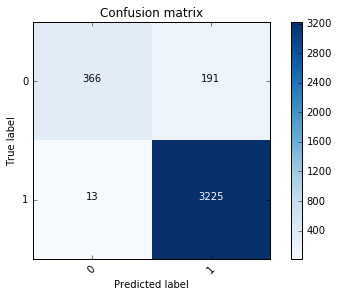

In [23]:
mnbModel.fit(X_tr_tfidf, y_tr)

y_p = mnbModel.predict(X_te_tfidf)

cfr = confusion_matrix(y_te, y_p)

plot_confusion_matrix(cfr, [0, 1])

### Best Standalone Model

#### Penalized Logistic Regression with doc2vec Vectorization

In [24]:
logisticModel = LogisticRegression()

show_results(logisticModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.9815546772068511

Precision/Recall/F-Score/Support: 

(array([ 0.94589552,  0.98741945]),
 array([ 0.92518248,  0.99106868]),
 array([ 0.93542435,  0.9892407 ]),
 array([ 548, 3247]))

Confusion Matrix:

array([[ 507,   41],
       [  29, 3218]])


Confusion matrix, without normalization
[[ 507   41]
 [  29 3218]]


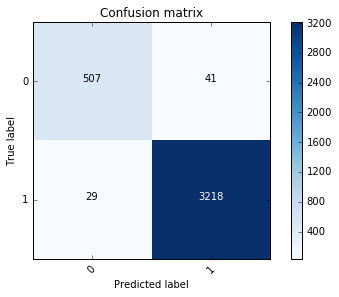

In [25]:
logisticModel.fit(X_tr_d2v, y_tr_d2v)

y_p = logisticModel.predict(X_te_d2v)

cfr = confusion_matrix(y_te_d2v, y_p)

plot_confusion_matrix(cfr, [0, 1])

### Blended Model

Logistic Regression as Level 0 Learner  
SVM with rbf kernel as Level 1 or Meta-Learner

In [38]:
level_zero = [LogisticRegression()]
level_one = SVC(kernel='rbf', gamma=10)

learner_dict = {0: level_zero, 1: level_one}
blender = Blender(2, learner_dict, verbose=False)

blender.fit(X_tr_d2v, y_tr_d2v, num_folds=500)

y_p = blender.predict(X_te_d2v)

precision_recall_fscore_support(y_te_d2v, y_p)

(array([ 0.93478261,  0.99013259]),
 array([ 0.94160584,  0.98891284]),
 array([ 0.93818182,  0.98952234]),
 array([ 548, 3247]))

Confusion matrix, without normalization
[[ 516   32]
 [  36 3211]]


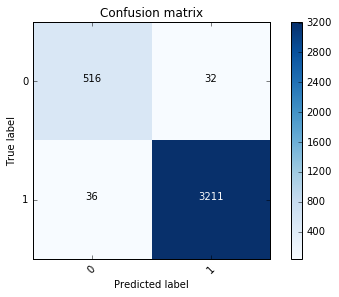

In [39]:
cfr = confusion_matrix(y_te_d2v, y_p)

plot_confusion_matrix(cfr, [0, 1])

### Other Good Standalone Models

#### Support Vector Machine with doc2vec Vectorization

In [35]:
svmModel = SVC(kernel='linear')

show_results(svmModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.9783926218708827

Precision/Recall/F-Score/Support: 

(array([ 0.93470149,  0.9855784 ]),
 array([ 0.91423358,  0.98922082]),
 array([ 0.92435424,  0.98739625]),
 array([ 548, 3247]))

Confusion Matrix:

array([[ 501,   47],
       [  35, 3212]])


#### Truncated SVD (reduced to 100 components) with Gradient Boosted Tree and TFIDF Vectorization

In [36]:
reducerGB = TruncatedSVD(n_components = 100)
modelGB = GradientBoostingClassifier(learning_rate = .5, n_estimators = 1000, max_depth = 2)
pipelineGB = Pipeline([('svd', reducerGB), ('GB', modelGB)])

show_results(pipelineGB, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9765480895915678

Precision/Recall/F-Score/Support: 

(array([ 0.93494424,  0.98342033]),
 array([ 0.90305206,  0.98919086]),
 array([ 0.91872146,  0.98629715]),
 array([ 557, 3238]))

Confusion Matrix:

array([[ 503,   54],
       [  35, 3203]])


#### Truncated SVD (reduced to 100 components) with SVM and TFIDF Vectorization

In [40]:
reducerSVM = TruncatedSVD(n_components = 300)
modelSVM = SVC(kernel='linear', probability = True)
pipelineSVM = Pipeline([('svd', reducerSVM), ('SVM', modelSVM)])

show_results(pipelineSVM, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9770750988142293

Precision/Recall/F-Score/Support: 

(array([ 0.94676806,  0.98195167]),
 array([ 0.8940754 ,  0.99135269]),
 array([ 0.91966759,  0.98662978]),
 array([ 557, 3238]))

Confusion Matrix:

array([[ 498,   59],
       [  28, 3210]])


## All Other Models

### Naive Bayes

#### Count Vectorization

In [147]:
mnbModel = MultinomialNB()

show_results(mnbModel, X_tr_count, X_te_count, y_tr, y_te)

Accuracy Score: 0.7191040843214757

Precision/Recall/F-Score/Support: 

(array([ 0.14553314,  0.84746856]),
 array([ 0.17595819,  0.81589568]),
 array([ 0.15930599,  0.83138247]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 101,  473],
       [ 593, 2628]])


#### TFIDF Vectorization

In [148]:
show_results(mnbModel, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9486166007905138

Precision/Recall/F-Score/Support: 

(array([ 0.97022333,  0.94604953]),
 array([ 0.68118467,  0.99627445]),
 array([ 0.80040942,  0.97051263]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 391,  183],
       [  12, 3209]])


In [18]:
y_p_mnb_baseline = y_p

#### Doc2Vec Vectorization

In [150]:
gnbModel = GaussianNB()

show_results(gnbModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.8476943346508564

Precision/Recall/F-Score/Support: 

(array([ 0.50312221,  0.9921466 ]),
 array([ 0.96410256,  0.82647975]),
 array([ 0.66119578,  0.90176751]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 564,   21],
       [ 557, 2653]])


### Logistic Regression

#### Count Vectorization

In [151]:
logisticModel = LogisticRegression()

show_results(logisticModel, X_tr_count, X_te_count, y_tr, y_te)

Accuracy Score: 0.8310935441370224

Precision/Recall/F-Score/Support: 

(array([ 0.17475728,  0.84940412]),
 array([ 0.03135889,  0.97361068]),
 array([ 0.05317578,  0.90727615]),
 array([ 574, 3221]))

Confusion Matrix:

array([[  18,  556],
       [  85, 3136]])


#### TFIDF Vectorization

In [152]:
show_results(logisticModel, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9723320158102767

Precision/Recall/F-Score/Support: 

(array([ 0.96806387,  0.97298118]),
 array([ 0.84494774,  0.9950326 ]),
 array([ 0.90232558,  0.98388335]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 485,   89],
       [  16, 3205]])


#### word2vec Vectorization

In [153]:
show_results(logisticModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.9839262187088273

Precision/Recall/F-Score/Support: 

(array([ 0.95017182,  0.99004046]),
 array([ 0.94529915,  0.99096573]),
 array([ 0.94772922,  0.99050288]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 553,   32],
       [  29, 3181]])


### Decision Tree

#### Count Vectorization

In [154]:
dtModel = DecisionTreeClassifier()

show_results(dtModel, X_tr_count, X_te_count, y_tr, y_te)

Accuracy Score: 0.7433465085638998

Precision/Recall/F-Score/Support: 

(array([ 0.15397924,  0.84923842]),
 array([ 0.15505226,  0.84818379]),
 array([ 0.15451389,  0.84871078]),
 array([ 574, 3221]))

Confusion Matrix:

array([[  89,  485],
       [ 489, 2732]])


#### TFIDF Vectorization

In [155]:
show_results(dtModel, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9420289855072463

Precision/Recall/F-Score/Support: 

(array([ 0.8172043 ,  0.96354649]),
 array([ 0.79442509,  0.96833282]),
 array([ 0.80565371,  0.96593373]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 456,  118],
       [ 102, 3119]])


#### word2vec Vectorization

In [156]:
show_results(dtModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.8490118577075099

Precision/Recall/F-Score/Support: 

(array([ 0.51056338,  0.90858382]),
 array([ 0.4957265 ,  0.91339564]),
 array([ 0.50303556,  0.91098338]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 290,  295],
       [ 278, 2932]])


### Random Forest

#### Count Vectorization

In [160]:
forestModel = RandomForestClassifier(n_estimators = 100)

show_results(forestModel, X_tr_count, X_te_count, y_tr, y_te)

Accuracy Score: 0.833201581027668

Precision/Recall/F-Score/Support: 

(array([ 0.10666667,  0.84784946]),
 array([ 0.01393728,  0.97919901]),
 array([ 0.02465331,  0.90880277]),
 array([ 574, 3221]))

Confusion Matrix:

array([[   8,  566],
       [  67, 3154]])


In [162]:
show_results(forestModel, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9657444005270093

Precision/Recall/F-Score/Support: 

(array([ 0.98684211,  0.96286313]),
 array([ 0.78397213,  0.99813722]),
 array([ 0.87378641,  0.98018293]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 450,  124],
       [   6, 3215]])


In [161]:
show_results(forestModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.8848484848484849

Precision/Recall/F-Score/Support: 

(array([ 0.98684211,  0.88059292]),
 array([ 0.25641026,  0.99937695]),
 array([ 0.40705563,  0.93623231]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 150,  435],
       [   2, 3208]])


### Adaboost

#### Count Vectorization

In [164]:
adaModel = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 100, learning_rate = 1.0)

show_results(adaModel, X_tr_count, X_te_count, y_tr, y_te)

Accuracy Score: 0.8205533596837945

Precision/Recall/F-Score/Support: 

(array([ 0.15923567,  0.84909291]),
 array([ 0.04355401,  0.95901894]),
 array([ 0.06839945,  0.90071439]),
 array([ 574, 3221]))

Confusion Matrix:

array([[  25,  549],
       [ 132, 3089]])


#### TFIDF Vectorization

In [165]:
show_results(adaModel, X_tr_tfidf, X_te_tfidf, y_tr, y_te)

Accuracy Score: 0.9407114624505929

Precision/Recall/F-Score/Support: 

(array([ 0.80994671,  0.9634901 ]),
 array([ 0.79442509,  0.9667805 ]),
 array([ 0.80211082,  0.9651325 ]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 456,  118],
       [ 107, 3114]])


#### word2vec Vectorization

In [166]:
show_results(adaModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.8397891963109354

Precision/Recall/F-Score/Support: 

(array([ 0.48006932,  0.90428838]),
 array([ 0.47350427,  0.90654206]),
 array([ 0.4767642 ,  0.90541381]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 277,  308],
       [ 300, 2910]])


### Gradient Boost

#### Count Vectorization

In [181]:
gbModel = GradientBoostingClassifier(learning_rate = .5, n_estimators = 1000, max_depth = 2)

show_results(gbModel, X_tr_count.toarray(), X_te_count.toarray(), y_tr, y_te)

Accuracy Score: 0.8194993412384717

Precision/Recall/F-Score/Support: 

(array([ 0.1595092 ,  0.84911894]),
 array([ 0.04529617,  0.95746663]),
 array([ 0.07055631,  0.90004378]),
 array([ 574, 3221]))

Confusion Matrix:

array([[  26,  548],
       [ 137, 3084]])


#### TFIDF Vectorization

In [183]:
gbModel = GradientBoostingClassifier(learning_rate = .5, n_estimators = 1000, max_depth = 2)

show_results(gbModel, X_tr_tfidf.toarray(), X_te_tfidf.toarray(), y_tr, y_te)

Accuracy Score: 0.9818181818181818

Precision/Recall/F-Score/Support: 

(array([ 0.97020484,  0.98373235]),
 array([ 0.90766551,  0.9950326 ]),
 array([ 0.93789379,  0.98935021]),
 array([ 574, 3221]))

Confusion Matrix:

array([[ 521,   53],
       [  16, 3205]])


In [ ]:
staged_MSE_train = [mean_squared_error(y_p, y_tr_d2v) for y_p in gbModel.staged_predict(X_tr_d2v)]
staged_MSE_test = [mean_squared_error(y_p, y_te_d2v) for y_p in gbModel.staged_predict(X_te_d2v)]

plt.plot(staged_MSE_train)
plt.plot(staged_MSE_test)

#### word2vec Vectorization

In [187]:
gbModel = GradientBoostingClassifier(learning_rate = .5, n_estimators = 2000, max_depth = 2)

show_results(gbModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.9744400527009223

Precision/Recall/F-Score/Support: 

(array([ 0.93571429,  0.98114374]),
 array([ 0.8957265 ,  0.98878505]),
 array([ 0.91528384,  0.98494957]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 524,   61],
       [  36, 3174]])


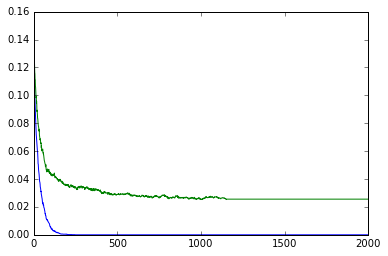

In [188]:
staged_MSE_train = [mean_squared_error(y_p, y_tr_d2v) for y_p in gbModel.staged_predict(X_tr_d2v)]
staged_MSE_test = [mean_squared_error(y_p, y_te_d2v) for y_p in gbModel.staged_predict(X_te_d2v)]

plt.plot(staged_MSE_train)
plt.plot(staged_MSE_test)

## SVM

In [189]:
svmModel = SVC(kernel='linear')

show_results(svmModel, X_tr_d2v, X_te_d2v, y_tr_d2v, y_te_d2v)

Accuracy Score: 0.9802371541501976

Precision/Recall/F-Score/Support: 

(array([ 0.93220339,  0.98907956]),
 array([ 0.94017094,  0.98753894]),
 array([ 0.93617021,  0.98830865]),
 array([ 585, 3210]))

Confusion Matrix:

array([[ 550,   35],
       [  40, 3170]])
